# Sign Language Estimation using Action Detection

<p style="text-align:center;">
    <img src="images/sign-language-character-gesture.jpg" alt="gestures" title="Sign-Language Gestures" width="1000"><br>
    <center><i>Image Source: <a href="https://whatsscience.in/how-deaf-scientists-communicate-on-the-global-platform/">What’s Science</a></i></center>
</p>

## Introduction

### Aim

In this project, we aim to perform real-time sign language detection flow using video sequences (multiple frames) with the help of LSTM Deep Learning model.

### Objective

In order to improve a sign language model, we will leverage action detection. Specifically, we will use a **key-point detection model** to build a sequence of key-points which can then be passed to an action detection model to decode sign language. As part of the model building process, we'll be using `Tensorflow` and `Keras` to build a deep neural network that leverages LSTM layers to handle the sequence of key-points.

### Summary

This project report is divided into the following parts:

1. Extract MediaPipe Holistic key-points :

> Collecting sequences of data on different key-points from our hands, body and face using MediaPipe Holistic and saving them as `numpy` arrays.

2. Build a sign language model using Action Detection powered by LSTM layers :

> Training a deep neural network using LSTM layers to predict actions from the sequence of frames, using `Tensorflow` and `Keras`.

3. Make real-time predictions in `OpenCV` :

> Combining the video sequences altogether in `OpenCV` and predicting in real-time using a webcam.

## Project Prerequisites

### Create Virtual Environment

We first setup a new virtual environment and name it `sign-env` and then activate it. Next, we install `ipykernel` which provides the IPython kernel for Jupyter and add our virtual environment. 

In [1]:
!python -m venv sign-env
!.\sign-env\Scripts\activate
!python -m ipykernel install --user --name=sign-env

Installed kernelspec sign-env in C:\Users\de777\AppData\Roaming\jupyter\kernels\sign-env


After this, we refresh the Jupyter notebook and switch to kernel `sign-env` by navigating to :

`Toolbar Menu` $\rightarrow$ `Kernel` $\rightarrow$ `Change kernel` $\rightarrow$ `sign-env`.

### Setup Required Dependencies

Next, we install and import all the following required libraries :
- `tensorflow` : to develop and train neural networking model
- `tensorflow-gpu` : to leverage dedicated GPU (NVIDIA) for tensorflow
- `opencv-python` : to work with webcams and build our feed
- `mediapipe` : to extract the key-points ([Click to see more details](https://google.github.io/mediapipe/solutions/holistic.html))
- `sklearn` : for train-test split and evaluation metrics
- `matplotlib` : to visualize images better
- `numpy` : to work with array structures
- `os` : to work with file paths
- `time` : to take a sleep between each frame collected

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib
 
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Extract Key-points

We will start by setting up two variables - one for MediaPipe Holistic model and other for MediaPipe Drawing Utilities. Holistic is going to be downloading the model and leveraging it to make detections, whereas the Drawing Utility is just going to make it easier to actually draw the key-points on our face. We will be setting these up as functions eventually because we are going to use them so often.

In [3]:
mp_holistic = mp.solutions.holistic     # holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

Next, we will set up a function to make our detection, wherein we will pass two variables - `image` and `model`. Here, first up, we grab the image and convert it from BGR (Blue Green Red) to RGB (Red Green Blue) color space using `cv2.cvtColor` function. We then set it to unwritable to save a little bit of memory, make our detections, set it back to writable and lastly, convert it again from RGB to BGR. The reason we make the color space conversion is that OpenCV reads the channel feed in BGR by default, but we need it to be in RGB format when we actually proceed to make detection using MediaPipe.

So, this `mediapipe_detection` function is going to return our image and results back to the loop in which we'll be using this function later.

In [4]:
# function to make detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color space from BGR to RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # predictions
    image.flags.writeable = True                   # image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert color space from RGB to BGR
    return image, results

The typical results of a MediaPipe Holistic model predictions contain different types of landmarks for face, hands and pose. These are represented as `x` (x-axis position), `y` (y-axis position) and `z` (relative distance to camera) values. 

To visualize these landmarks, we will define a function to grab the landmark results & render them onto the current image by applying formatting for face, hands (left and right) and pose connections. For this, we will use the MediaPipe Drawing Utilities function that we setup initially. Here, we will pass through the following parameters: 
- image
- landmark list to be received from model
- type of connection map
- formatting for joints (dots)
- formatting for connections (lines)

For the formatting part, we will set different suitable colors (in BGR format), thicknesses and circle radius values.

**Notes :**
- Face and hand landmark models will return no values if nothing is detected.
- Pose model will return landmarks but the visibility value inside each landmark will be low.
- It is to be noted that `draw_landmarks` function doesn't return the image, but rather applies the landmark visualizations to the current image in place.

In [5]:
def draw_styled_landmarks(image, results):
    
    # face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 255, 86), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1))
    
    # pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2)) 
    
    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))
    
    # right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))

Now, we will define a real-time loop to set our MediaPipe model. 

For that, first we will instantiate or access our Holistic model with suitable initial detection confidence and proceeding tracking confidence parameters. While making sure that we can access our webcam using `OpenCV`, we will first setup video capture from the webcam feed and then loop through every single frame of it. Here, we will call the `mediapipe_detection` function defined previously to make detections on each frame and return the results. So, even though we loop through a frame, it looks like a video as essentially videos are multiple frames stacked together. After making detections, we will draw our formatted landmarks on the images and render them to the screen. Lastly, to escape from the loop we will set it to wait 10 seconds for the key `Q` on the keyboard to be pressed. Once it breaks, we will release the webcam and close down all frames, so that the loop is broken gracefully with no errors.

**Notes :**
- On running the loop, if a pop-up (representing the frames) appears briefly and then closes, we need to re-run the cell again. If the pop-up doesn't appear at all, we need to play with the device number which is '0' in our case. This device number corresponds to the webcam device on a particular system. So if there are any virtual devices setup for a system, this device number for the webcam access might be different.


- If this particular walkthrough is intended to be performed a particular video file, we can actually substitute this device value for the video name. Although we can perform the detections on a video, it is however recommended initially we actually train using real-time webcam.

In [6]:
cap = cv2.VideoCapture(0) # read the feed from webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # double-check for webcam access & loop through all frames

        # read feed/frames from webcam
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)
        
        # show image to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

We will now visualize the last frame extracted from the webcam using `plt.imshow` function after applying the landmarks obtained from the detection results and performing color conversion on the frame in place.

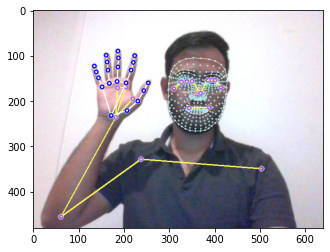

In [7]:
draw_styled_landmarks(frame, results) # apply landmarks
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # color conversion

## Extract Key-point Values

In the next step, we will start extracting the key-point values into a usable format. We can access the different components of our model results to visualize which landmarks have been detected.

In [8]:
results.pose_landmarks

landmark {
  x: 0.5780841
  y: 0.38297418
  z: -0.8868346
  visibility: 0.99993104
}
landmark {
  x: 0.6028043
  y: 0.3209902
  z: -0.82204163
  visibility: 0.99983823
}
landmark {
  x: 0.61588866
  y: 0.32122928
  z: -0.8219538
  visibility: 0.9997565
}
landmark {
  x: 0.6280551
  y: 0.32176745
  z: -0.822138
  visibility: 0.9997915
}
landmark {
  x: 0.54948103
  y: 0.32601467
  z: -0.8084389
  visibility: 0.99987787
}
landmark {
  x: 0.5302981
  y: 0.32793522
  z: -0.8080493
  visibility: 0.9998688
}
landmark {
  x: 0.5116774
  y: 0.33048418
  z: -0.8082367
  visibility: 0.99992454
}
landmark {
  x: 0.6491133
  y: 0.35426056
  z: -0.42291865
  visibility: 0.9996851
}
landmark {
  x: 0.48541993
  y: 0.36167875
  z: -0.34193593
  visibility: 0.9999249
}
landmark {
  x: 0.608805
  y: 0.44730562
  z: -0.74935246
  visibility: 0.9999238
}
landmark {
  x: 0.5385646
  y: 0.44894522
  z: -0.72712356
  visibility: 0.9999562
}
landmark {
  x: 0.78774774
  y: 0.7287998
  z: -0.2076612
  visibil

To extract these components in a more resilient way, we will concatenate them into a `numpy` array such that if there are no values at any instance, we will create a `numpy` zeros array of same shape and substitute that in. 

So, we will define a function `extract_keypoints`, wherein we will pass the MediaPipe detection results. Using list comprehension we will first extract the keypoints, convert them into `numpy` arrays, and then effectively reshape/flatten them into a single big array format required for passing to LSTM model. For error handling in case of missing landmark values (if hands or face isn't in frame), we will incorporate `if` statement to return a blank or zero array to replace the missing values. This placeholder array will have the same number of landmarks, i.e., `x`, `y`, and `z` values for each type. So, respective total number of landmarks would be :

- Pose : $33 × 4 = 132$ for `x`, `y`, `z` & `visibility` values
- Face : $468 × 3 = 1404$ for `x`, `y` & `z` values
- Left hand : $21 ×  3 = 63$ for `x`, `y` & `z` values
- Right hand : $21 × 3 = 63$ for `x`, `y` & `z` values

Finally, we will concatenate all the four sets of key-points. Therefore, the total no. of landmarks in the single flattened array would be $132 + 1404 + 63 + 63 = 1662$.

In [9]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
        
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

Now, when we run the above function on our MediaPipe results, we will get all of our values as a single flattened array. And on checking the length of this array, we can see that it is $1662$, i.e. it has all of the values.

In [10]:
extract_keypoints(results)

array([ 0.57808411,  0.38297418, -0.88683462, ...,  0.21186748,
        0.25803787, -0.02404926])

In [11]:
extract_keypoints(results).shape

(1662,)

## Folder Setup for Collection

Now, we will start setting up folders for array collection. For this, we will first setup four new variables :

- `data_path` : Path for storing the exported data, i.e. the `numpy` arrays
- `actions` : Actions that we try to detect, namely "hello", "thanks", & "I love you"
- `no_sequences` : 30 videos of data to be collected for each action
- `sequence_length` : Each video is of 30 frames in length

We will use a sequence of data rather than a single frame for detection. Here, we will be using 30 frames, i.e., effectively 30 different sets of proceeding key-points to be able to classify an action. In nutshell, we will be collecting 30 videos per action where each video will be containing 30 frames of data and each frame will contain 1662 landmark values.

In [12]:
data_path = os.path.join('MP_Data') #path for exported data

actions = np.array(['hello', 'thanks', 'iloveyou']) #actions to be detected

no_sequences = 30 #no. of videos collected for each action

sequence_length = 30 #frame length of each video

Next, we will create separate folders to store data for each of the actions. So, each one of our 30 frames are going to be stored inside these folders in subdirectories. For this, we will loop through all of the different actions and then loop through the sequences (30 different videos). Then, we will try to run and make the directories. For error handling in case a directory doesn't exist, we will make use of the `try-except` block.

In [13]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

After running the above code chunk, we will navigate to our working directory to check for the newly created directories and subdirectories. We will find a `MP_Data` folder, inside which we will find three folders for the actions - `hello`, `iloveyou`, `thanks`. Now inside each of these folders, we will have the individual sequence folders - `0`, `1`, `2`, `3` and so on. And eventually inside each of these sequence folders, we will be having 30 different arrays worth of data from our key-points. 

## Collect Key-point Values for Train & Test

Now, we will begin collecting all the key-point data. For this, we will setup video capture looping through each frame.

Rather than consistently looping through our web-cam, we will actually loop through and specifically take a snapshot at each instance of time. So, we will first loop through each one of our three actions, then through 30 videos/sequences and finally through a set of 30 frames per video. In this way, we will collect 30 videos with 30 frames of key-points per video.

We will also apply a collection break of 1.5 seconds between each one of the videos being collected. Having breaks between each sequence collection will allow us to reset and reposition ourselves (the subject of image) in order to collect each action from start to finish. In the collection logic, we will incorporate outputting custom formatted text to the screen to know when frames and sequences are starting.

For the key-point extraction part, we will save each frame as a `numpy` array into respective folders inside `MP_Data`. Now, as soon we run the code chunk below, we will start collecting our key-points for the three actions one-by-one. We will try to perform the actions using both left and right hands periodically and in different angles for the model to perform better.

In [14]:
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    #NEW LOOP
    for action in actions: # loop through actions
        for sequence in range(no_sequences): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 

                # read frames
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW collection wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200), 
                                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # 1.5 seconds break
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

## Pre-process Data and Create Lables & Features

Now that our data has been collected, we will start with preprocessing it and create labels and features. Firstly, we will import the following two additional dependencies :

  - `train_test_split` function from `scikit-learn`: to create training and testing partitions
  - `to_categorical` function form `keras` : to help with labels (convert data into one-hot-encoded format)

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Now, we will create a label map which is actually a label array or dictionary to represent each one of our different actions. So, we will be creating a segment or a set of labels which represents different IDs - `0`, `1` and `2`. We will use this when we start to create our training and testing data.

In [16]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

Next, we will start bringing all our data together and structure it. So, we will create one big array which actually contains all of our data, effectively, $90$ arrays with $30$ frames in each one of those arrays with $1662$ values representing our key-points in each.

So, firstly we will create two blank arrays :
- `sequences` that will represent our feature or `x` data
- `labels` that will represent our labels or `y` data

We will be using our features to train a model to represent the relationship between our labels. Looping through each of our actions followed by sequences, we will create a blank array `window` that will represent all of the different frames we have got for a particular sequence. Then, we will loop through each one of our frames and append them to `window`. Once done, we will append `window` array for the particular sequence to `sequences` array. Finally, we will append the label map defined earlier to the `labels` array.

In [17]:
sequences, labels = [], [] # blank arrays
for action in actions:
    for sequence in range(no_sequences):
        window = [] # blank array
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

On checking the dimensions of `sequences` array, it can be confirmed we have got $90$ videos with $30$ frames each and each one of those has $1662$ key-points.

In [18]:
np.array(sequences).shape

(90, 30, 1662)

If we take a look at the dimensions of `labels`, it can be confirmed that we have got total $90$ different videos for all the actions.

In [19]:
np.array(labels).shape

(90,)

We will now pre-process this to get it into a format that we can start working with. So, we will store the `sequences` inside of a `numpy` array. Using `to_categorical` function, we will perform one-hot-encoding of `labels`.

In [20]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding

Next, using `train_test_split` function we will perform training and testing partition with the test partition size being 5% of the data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

## Build & Train LSTM Neural Network

To train our LSTM neural network, first we will be importing the following key dependencies:
- `Sequential` modeling : allows us to build a sequential neural network
- `LSTM` layer : provides temporal component for the Neural Network & allows performing action detection
- `Dense` layer : a normal fully connected layer
- `TensorBoard` : allows to perform logging inside TensorBoard web app for tracing & monitoring model during training

In [22]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard 

Next, we will create a log directory and set up our TensorBoard callbacks to monitor our neural network training and its accuracy as its being trained.

In [23]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

Now, we will be building up our neural network architecture. We will first instantiate the model, specifically the Sequential API that makes it easy to build up our model by adding in a bunch of layers. Then, we will add a LSTM layer of 64 units with the input shape of $(30, 1662)$ representing 30 frames/prediction multiplied by 1662 values. After this, we will add two more LSTM layers of 128 and 64 units. For the last layer with 64 units, we will set `return_sequences = False` as next layer will be a Dense layer, so we require to not return the sequences to that layer.

The next 3 layers will be dense or fully-connected layers. The first two layers will have 64 and 32 units, and the final layer will be the actions layer. For the actions layer, we will have 3 LSTM units represented by `actions.shape[0]`. `activation='softmax'` is going to return values with a probability between 0 & 1, such that the sum of all values add up to 1. Here, the highest value represents the action that's been detected.

In [24]:
model = Sequential() 

# add 3 set of LSTM layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) 

# add 3 Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # actions layer

>**IMPORTANT NOTE : *Why are we using this type of neural network with MediaPipe + LSTM layers ?***
>
>State-of-the-art models currently in use tend to use a number of CNN layers followed by a number of LSTM layers, with specifically some of them using a pre-trained MobileNet followed by a number of LSTM layers. But in our case, when we trained with a similar number of sequences, the level of accuracy produced was nowhere near useful. So, the MediaPipe + LSTM layers approach was chosen mainly because:
>
>1. *Less data required* : We needed less data to produce a hyper accurate model.
>2. *Faster to train* : It was a much denser neural network. So, instead of having 30-40 million parameters in the neural network, we had about half a million parameters, which means it was going to be way faster to go ahead and train the particular model.
>3. *Faster detections* : Because the neural network was much simpler, it is going to be hugely faster when it comes to detecting in real-time.

Now, we are going to compile our model and fit it.

In the parameters, we will specify `Adam` as the optimizer, `categorical_crossentropy` as the loss function since its used for multi-class classification models and `categorical_accuracy` as the metrics to track the model accuracy as we train.

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

As we train our model, in the meantime to view the Tensorflow logs in TensorBoard we will perform the following steps:
- Open CMD (or Anaconda CMD) and navigate to the log directory (training folder)
- Execute: `tensorboard --logdir=.`

On successful execution of the command, we will get a link like: http://localhost:6006/, that we need to copy and open in any web browser. We can then see our model running and check performance of categorical training accuracy. Also, we can take a look at our neural network architecture, time series data etc.

We will now fit and train our model. Here, we will set the epochs to 1000, which might be high for training with such a low amount of data. So, training may be stopped early if accuracy is acceptable and loss has stopped consistently decreasing.

In [26]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
3/3 [==============================] - 3s 75ms/step - loss: 1.4220 - categorical_accuracy: 0.4353
Epoch 2/1000
3/3 [==============================] - 0s 68ms/step - loss: 5.0808 - categorical_accuracy: 0.3059
Epoch 3/1000
3/3 [==============================] - 0s 74ms/step - loss: 3.6850 - categorical_accuracy: 0.3529
Epoch 4/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.5107 - categorical_accuracy: 0.2706
Epoch 5/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.7086 - categorical_accuracy: 0.3529
Epoch 6/1000
3/3 [==============================] - 0s 65ms/step - loss: 2.6590 - categorical_accuracy: 0.3529
Epoch 7/1000
3/3 [==============================] - 0s 57ms/step - loss: 1.8083 - categorical_accuracy: 0.3176
Epoch 8/1000
3/3 [==============================] - 0s 59ms/step - loss: 1.4361 - categorical_accuracy: 0.3176
Epoch 9/1000
3/3 [==============================] - 0s 65ms/step - loss: 1.3936 - categorical_accuracy: 0.3294
E

3/3 [==============================] - 0s 69ms/step - loss: 1.8359 - categorical_accuracy: 0.2824
Epoch 75/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.6043 - categorical_accuracy: 0.3412
Epoch 76/1000
3/3 [==============================] - 0s 77ms/step - loss: 1.6912 - categorical_accuracy: 0.3176
Epoch 77/1000
3/3 [==============================] - 0s 79ms/step - loss: 1.1775 - categorical_accuracy: 0.3529
Epoch 78/1000
3/3 [==============================] - 0s 74ms/step - loss: 1.2824 - categorical_accuracy: 0.3176
Epoch 79/1000
3/3 [==============================] - 0s 60ms/step - loss: 1.3556 - categorical_accuracy: 0.2471
Epoch 80/1000
3/3 [==============================] - 0s 54ms/step - loss: 1.1713 - categorical_accuracy: 0.3176
Epoch 81/1000
3/3 [==============================] - 0s 60ms/step - loss: 1.1415 - categorical_accuracy: 0.3529
Epoch 82/1000
3/3 [==============================] - 0s 62ms/step - loss: 1.1626 - categorical_accuracy: 0.3059
Epoch 

3/3 [==============================] - 0s 71ms/step - loss: 1.0948 - categorical_accuracy: 0.3647
Epoch 147/1000
3/3 [==============================] - 0s 69ms/step - loss: 1.1615 - categorical_accuracy: 0.2235
Epoch 148/1000
3/3 [==============================] - 0s 62ms/step - loss: 1.0981 - categorical_accuracy: 0.2824
Epoch 149/1000
3/3 [==============================] - 0s 59ms/step - loss: 1.1089 - categorical_accuracy: 0.4235
Epoch 150/1000
3/3 [==============================] - 0s 59ms/step - loss: 1.1487 - categorical_accuracy: 0.3412
Epoch 151/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.0855 - categorical_accuracy: 0.3059
Epoch 152/1000
3/3 [==============================] - 0s 63ms/step - loss: 1.0918 - categorical_accuracy: 0.4471
Epoch 153/1000
3/3 [==============================] - 0s 67ms/step - loss: 1.1094 - categorical_accuracy: 0.3529
Epoch 154/1000
3/3 [==============================] - 0s 64ms/step - loss: 1.1715 - categorical_accuracy: 0.482

3/3 [==============================] - 0s 57ms/step - loss: 0.8689 - categorical_accuracy: 0.5529
Epoch 219/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.8789 - categorical_accuracy: 0.4941
Epoch 220/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.8800 - categorical_accuracy: 0.6235
Epoch 221/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.8642 - categorical_accuracy: 0.6235
Epoch 222/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.8716 - categorical_accuracy: 0.4941
Epoch 223/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.8853 - categorical_accuracy: 0.6353
Epoch 224/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.8795 - categorical_accuracy: 0.6118
Epoch 225/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.8767 - categorical_accuracy: 0.6235
Epoch 226/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.8875 - categorical_accuracy: 0.411

3/3 [==============================] - 0s 70ms/step - loss: 0.7330 - categorical_accuracy: 0.6706
Epoch 291/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.7238 - categorical_accuracy: 0.7059
Epoch 292/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.7281 - categorical_accuracy: 0.7176
Epoch 293/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.7562 - categorical_accuracy: 0.6471
Epoch 294/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.9071 - categorical_accuracy: 0.5765
Epoch 295/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.8104 - categorical_accuracy: 0.5412
Epoch 296/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.8434 - categorical_accuracy: 0.5765
Epoch 297/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.8750 - categorical_accuracy: 0.5529
Epoch 298/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.8344 - categorical_accuracy: 0.564

3/3 [==============================] - 0s 61ms/step - loss: 0.5582 - categorical_accuracy: 0.8588
Epoch 363/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.6464 - categorical_accuracy: 0.6941
Epoch 364/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.6401 - categorical_accuracy: 0.7294
Epoch 365/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.7965 - categorical_accuracy: 0.5412
Epoch 366/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.7851 - categorical_accuracy: 0.5059
Epoch 367/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.6649 - categorical_accuracy: 0.6353
Epoch 368/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.5339 - categorical_accuracy: 0.7529
Epoch 369/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.4930 - categorical_accuracy: 0.8000
Epoch 370/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.4950 - categorical_accuracy: 0.882

3/3 [==============================] - 0s 66ms/step - loss: 0.4744 - categorical_accuracy: 0.7765
Epoch 435/1000
3/3 [==============================] - 0s 67ms/step - loss: 0.6855 - categorical_accuracy: 0.5412
Epoch 436/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.5478 - categorical_accuracy: 0.7176
Epoch 437/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.5112 - categorical_accuracy: 0.7529
Epoch 438/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.5404 - categorical_accuracy: 0.7294
Epoch 439/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.5121 - categorical_accuracy: 0.6118
Epoch 440/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.4864 - categorical_accuracy: 0.6706
Epoch 441/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.4578 - categorical_accuracy: 0.7647
Epoch 442/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.4426 - categorical_accuracy: 0.823

3/3 [==============================] - 0s 68ms/step - loss: 0.4954 - categorical_accuracy: 0.7059
Epoch 507/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4418 - categorical_accuracy: 0.6000
Epoch 508/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.4219 - categorical_accuracy: 0.7882
Epoch 509/1000
3/3 [==============================] - 0s 67ms/step - loss: 0.4350 - categorical_accuracy: 0.8118
Epoch 510/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4196 - categorical_accuracy: 0.8235
Epoch 511/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4126 - categorical_accuracy: 0.7882
Epoch 512/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4468 - categorical_accuracy: 0.7882
Epoch 513/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4585 - categorical_accuracy: 0.7176
Epoch 514/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.4958 - categorical_accuracy: 0.788

3/3 [==============================] - 0s 62ms/step - loss: 0.6211 - categorical_accuracy: 0.6706
Epoch 579/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.6398 - categorical_accuracy: 0.6588
Epoch 580/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.5763 - categorical_accuracy: 0.6941
Epoch 581/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.5758 - categorical_accuracy: 0.6824
Epoch 582/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.6150 - categorical_accuracy: 0.8000
Epoch 583/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.5582 - categorical_accuracy: 0.7529
Epoch 584/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.5174 - categorical_accuracy: 0.7765
Epoch 585/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.5105 - categorical_accuracy: 0.7529
Epoch 586/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.5017 - categorical_accuracy: 0.764

3/3 [==============================] - 0s 70ms/step - loss: 0.4257 - categorical_accuracy: 0.8235
Epoch 651/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.4536 - categorical_accuracy: 0.6353
Epoch 652/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4459 - categorical_accuracy: 0.8000
Epoch 653/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.4340 - categorical_accuracy: 0.7176
Epoch 654/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.4005 - categorical_accuracy: 0.7765
Epoch 655/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.4273 - categorical_accuracy: 0.8000
Epoch 656/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.4272 - categorical_accuracy: 0.6118
Epoch 657/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.5313 - categorical_accuracy: 0.7529
Epoch 658/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.6078 - categorical_accuracy: 0.600

3/3 [==============================] - 0s 54ms/step - loss: 0.3302 - categorical_accuracy: 0.8118
Epoch 723/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.3361 - categorical_accuracy: 0.8941
Epoch 724/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.3852 - categorical_accuracy: 0.8000
Epoch 725/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.3931 - categorical_accuracy: 0.7765
Epoch 726/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.3537 - categorical_accuracy: 0.7882
Epoch 727/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.3386 - categorical_accuracy: 0.8235
Epoch 728/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.3443 - categorical_accuracy: 0.9294
Epoch 729/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.4334 - categorical_accuracy: 0.7765
Epoch 730/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.5525 - categorical_accuracy: 0.576

3/3 [==============================] - 0s 75ms/step - loss: 0.5350 - categorical_accuracy: 0.4941
Epoch 795/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.4838 - categorical_accuracy: 0.8000
Epoch 796/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.4649 - categorical_accuracy: 0.6824
Epoch 797/1000
3/3 [==============================] - 0s 66ms/step - loss: 0.4400 - categorical_accuracy: 0.7059
Epoch 798/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.4189 - categorical_accuracy: 0.9412
Epoch 799/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.4113 - categorical_accuracy: 0.8588
Epoch 800/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.4000 - categorical_accuracy: 0.9294
Epoch 801/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.4133 - categorical_accuracy: 0.8118
Epoch 802/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.4297 - categorical_accuracy: 0.741

3/3 [==============================] - 0s 68ms/step - loss: 0.2609 - categorical_accuracy: 0.9412
Epoch 867/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.2530 - categorical_accuracy: 0.9059
Epoch 868/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.2062 - categorical_accuracy: 0.9765
Epoch 869/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.2392 - categorical_accuracy: 0.9176
Epoch 870/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.2158 - categorical_accuracy: 0.9647
Epoch 871/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.2116 - categorical_accuracy: 0.9529
Epoch 872/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.2102 - categorical_accuracy: 0.9412
Epoch 873/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.2519 - categorical_accuracy: 0.9176
Epoch 874/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.2811 - categorical_accuracy: 0.858

3/3 [==============================] - 0s 60ms/step - loss: 0.6087 - categorical_accuracy: 0.7412
Epoch 939/1000
3/3 [==============================] - 0s 63ms/step - loss: 2.2147 - categorical_accuracy: 0.4824
Epoch 940/1000
3/3 [==============================] - 0s 60ms/step - loss: 2.6464 - categorical_accuracy: 0.4824
Epoch 941/1000
3/3 [==============================] - 0s 64ms/step - loss: 2.6379 - categorical_accuracy: 0.3412
Epoch 942/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.7827 - categorical_accuracy: 0.6000
Epoch 943/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.9652 - categorical_accuracy: 0.4235
Epoch 944/1000
3/3 [==============================] - 0s 57ms/step - loss: 1.0413 - categorical_accuracy: 0.3412
Epoch 945/1000
3/3 [==============================] - 0s 59ms/step - loss: 1.0014 - categorical_accuracy: 0.3529
Epoch 946/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.8903 - categorical_accuracy: 0.341

When we see that we have already reach a reasonable accuracy level close to 1 and loss is close to 0, we stop the process. Now, we will visualize how our model looks like using the `summary()` function.

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

We can see that we have got 3 different LSTM layers followed by the 3 dense layers. Importantly, we have got a reasonably small number of parmeters to train, i.e., `596,675` (as opposed to around millions of parameters using a CNN layer). In our case, where we have less data, this LSTM method therefore works better.

## Make Predictions

Now, we will make the predictions on the test data based on this model.

In [28]:
res = model.predict(X_test)

We can check the prediction for a random action by unpacking the results.

In [29]:
actions[np.argmax(res[3])]

'iloveyou'

On checking the actual value for the same action in `y_text` data, we can see that it matches the prediction. So, we can see that model is performing pretty well here.

In [30]:
actions[np.argmax(y_test[3])]

'iloveyou'

## Save Weights

After we have trained our neural network, we will save the values for later usage under `fin_mod.h5`. An H5 file is a data file in Hierarchical Data Format HDF. It is a kind of library file used for storing large amounts of numerical, graphical and text data in the form of multidimensional arrays.

In [31]:
model.save('fin_mod.h5')

If we go to the working directory now, we will be able to see the file. In case we delete our model, we can do the following steps to reload it:

1. Run: `del model`
2. Go back up to section for model build and run it
3. Then compile it using the compile cell
4. Run: `model.load_weights('fin_mod.h5')`

## Model Evaluation

To check how the model is actual performing, we will do performance evaluation using confusion matrices and accuracy scores using metrics from `scikit-learn`.

In [32]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

A multi-label confusion matrix gives us a confusion matrix for each of the different labels, allowing us to evaluate what is being detected as a true positive and a true negative vs. a false positive and a false negative. So, first we will make some predictions on the `X_test` dataset.

In [33]:
yhat = model.predict(X_test)

We will then extract the predicted classes and convert the predictions from their one-hot-encoded representation to categorical labels, e.g., $0, 1, 2$ instead of $[1,0,0], [0,1,0], [0,0,1]$. And then, we will generate our multi-label confusion matrix using the `multilabel_confusion_matrix()` function. This will return a confusion matrix sorted by the label order, i.e., in this case 0, 1, 2 aka 'hello', 'thank you', 'i love you'.

In [34]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

Here, we get $2\times2$ confusion matrices in the following format :

[ [ TRUE NEGATIVE, FALSE POSITIVE ],

[ FALSE NEGATIVE, TRUE POSITIVE ] ]

Since all of our values are either in the top-left (TRUE POSITIVE) or in the bottom-right (TRUE NEGATIVE), our model is performing really well. Now, we will pass this to the accuracy score method. Higher the number we get here, better is the model performance.

In [35]:
accuracy_score(ytrue, yhat)

1.0

So, we get a 100% accuracy on our test set and this is due to a small test set. So, if we evaluated the model on the training data (which is not an ideal approach), we can visualize the same thing in a broader perspective.

In [36]:
yhat_t = model.predict(X_train)
ytrue_t = np.argmax(y_train, axis=1).tolist()
yhat_t = np.argmax(yhat_t, axis=1).tolist()
multilabel_confusion_matrix(ytrue_t, yhat_t)

array([[[56,  1],
        [ 0, 28]],

       [[57,  0],
        [ 0, 28]],

       [[56,  0],
        [ 1, 28]]], dtype=int64)

As we can see in this case, that the confusion matrix shows a very slightly lower performance. Running through the accuracy score function also gives us a lower value than before. However, the model is still performing reasonably well.

In [37]:
accuracy_score(ytrue_t, yhat_t)

0.9882352941176471

## Real-time Testing

In order to visualize the probabilities of detected action in real-time, we will define a function `prob_viz`. First, we will create an array `colors` for coloring of the arrays, one for each action. To the function definition, we will pass 4 positional arguments :
- results that we get from predicted model
- our actions
- our input frame, which is eventually going to be our image
- colors (defined at start)

Then we will make copy of our frame and loop through each of the results (the 3 different probability values) that we've got in our variables. For each of them, we will draw a dynamic rectangle and setup formatted output texts. Finally, we will return the output frame.

In [38]:
# render probabilites
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1) # drawing a dynamic rectangle
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1, cv2.LINE_AA)
    return output_frame

We will implement this function into our detection loop next to visualize probabilities in real-time.

To perform real-time detection, firstly we will be creating 4 new detection variables:

- `sequence`: to collect the 30 frames in order to be able to generate a prediction
- `sentence`: to concatenate history of the detections together
- `predictions`: to append all the predictions to this empty array
- `threshold`: acts like a confidence metric, i.e., results are rendered only if they're above this value

After following a similar loop for video capture and MediaPipe holistic model as we did before, we will implement our **prediction logic**. For this, we will extract the key-points and append them onto end of `sequence` array. Once we've grabbed the last 30 frames of data, we will be able to generate prediction. However, since initially we won't be actually having 30 frames, we will implement a logic such that the prediction runs only if length of `sequence` is 30. Here, `expand_dims` allows us to match the shape of sequence that model expects (1, 30, 1662) and pass through one sequence at a time rather than having to pass through a bunch.

For **visualization/rendering logic**, we will grab the last 10 unique predictions to check if they are exactly same in order to boost stability for action prediction and minimize false detections between two actions. Then, we will proceed with checking if our results are above threshold. If yes, next we will check if `sentence` array length is greater than zero, i.e., if we've any words in the array :
 - If not, we will append to it
 - If yes, we'll further check if current predicted word/action doesn't match the last word in `sentence` : 
   - If yes, we'll append the current action
   - If not, we'll skip appending to prevent duplication as our model is going to be continuously detecting
  
Next, we check if `sentence` length is above 5 words. If yes, we'll grab only the last 5 values to prevent ending up with a giant array to be rendered. We will then implement the `prob_viz` function defined previously to render the detection probabilities. Finally, to render the text for the detected action, we'll setup suitable formatting and sentence-concatenation.

In [39]:
#1. new detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # loop through all frames

        # read frames
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)        
#-------------------------------------------------------------------------
        #2. prediction logic
        keypoints = extract_keypoints(results) # extracting the keypoints
        sequence.append(keypoints)
        sequence = sequence[-30:] #grab last 30 frames
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
#            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))            
#-------------------------------------------------------------------------
        #3. visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                
                if res[np.argmax(res)] > threshold:
                
                    if len(sentence) > 0: #check for words in sentence
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        
            if len(sentence) > 5:
                sentence = sentence[-5:]
#-------------------------------------------------------------------------                
            #4. visualization probabilites
            image = prob_viz(res, actions, image, colors)
#-------------------------------------------------------------------------

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2, cv2.LINE_AA)
                               
        # show image on screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

## Conclusion

In this project, we have successfully leveraged a key-point detection model to effectively detect sign-language actions - 'hello', 'thank you' and 'i love you', all in real-time. Additionally, the probabilities of respective actions are rendered on to the screen, with their values automatically bumping up for the respective actions performed.

To roughly summarize everything, we performed the following tasks:

- installed and imported our dependencies
- built up all functions using MediaPipe holistic
- extracted our key-point values using abstract key-point function
- setup folders for collection, collected our key-points
- preprocessed our data
- built our LSTM neural network
- made our predictions
- eventually tested this out in real-time

There are a whole bunch of applications where we can implement this model. Also, we can add customize the model by adding additional actions, incorporating different colors, setting up different visualizations, etc.

--------------------------------------------------------